Rewritten based on https://github.com/kamalkraj/Named-Entity-Recognition-with-Bidirectional-LSTM-CNNs for self-learning purpose

In [2]:
import numpy as np 
from NER.validation import compute_f1
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,MaxPooling1D,Flatten,concatenate
from NER.prepro import readfile,createBatches,createMatrices,iterate_minibatches,addCharInformatioin,padding
from keras.utils import Progbar
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform

Using TensorFlow backend.


In [4]:
trainSentences = readfile("./NER/data/train.txt")
devSentences = readfile("./NER/data/valid.txt")
testSentences = readfile("./NER/data/test.txt")

In [19]:
len(trainSentences)

14041

In [20]:
trainSentences[0]

[['EU', 'B-ORG\n'],
 ['rejects', 'O\n'],
 ['German', 'B-MISC\n'],
 ['call', 'O\n'],
 ['to', 'O\n'],
 ['boycott', 'O\n'],
 ['British', 'B-MISC\n'],
 ['lamb', 'O\n'],
 ['.', 'O\n']]

In [21]:
trainSentences = addCharInformatioin(trainSentences)
devSentences = addCharInformatioin(devSentences)
testSentences = addCharInformatioin(testSentences)

In [22]:
trainSentences[0]

[['EU', ['E', 'U'], 'B-ORG\n'],
 ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'],
 ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC\n'],
 ['call', ['c', 'a', 'l', 'l'], 'O\n'],
 ['to', ['t', 'o'], 'O\n'],
 ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'],
 ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC\n'],
 ['lamb', ['l', 'a', 'm', 'b'], 'O\n'],
 ['.', ['.'], 'O\n']]

In [23]:
labelSet = set()
words = {}

for dataset in [trainSentences, devSentences, testSentences]:
    for sentence in dataset:
        for token,char,label in sentence:
            labelSet.add(label)
            words[token.lower()] = True

In [24]:
labelSet

{'B-LOC\n',
 'B-MISC\n',
 'B-ORG\n',
 'B-PER\n',
 'I-LOC\n',
 'I-MISC\n',
 'I-ORG\n',
 'I-PER\n',
 'O\n'}

In [54]:
for w, _ in zip(words, range(5)):
    print(w, words[w])
print("====")
print(len(words))

eu True
rejects True
german True
call True
to True
====
26869


In [27]:
# :: Create a mapping for the labels ::
label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx)
    
label2Idx

{'B-LOC\n': 0,
 'I-LOC\n': 1,
 'I-PER\n': 2,
 'I-ORG\n': 3,
 'B-PER\n': 4,
 'B-MISC\n': 5,
 'O\n': 6,
 'I-MISC\n': 7,
 'B-ORG\n': 8}

In [29]:
# :: Hard coded case lookup ::
case2Idx = {'numeric': 0, 'allLower':1, 'allUpper':2, 'initialUpper':3, 'other':4, 'mainly_numeric':5, 'contains_digit': 6, 'PADDING_TOKEN':7}
caseEmbeddings = np.identity(len(case2Idx), dtype='float32')
caseEmbeddings 

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [31]:
# :: Read in word embeddings ::
word2Idx = {}
wordEmbeddings = []
fEmbeddings = open("./NER/embeddings/glove.6B.100d.txt", encoding="utf-8")

In [33]:
for line in fEmbeddings:
    split = line.strip().split(" ")
    word = split[0]
    
    if len(word2Idx) == 0: #Add padding+unknown
        word2Idx["PADDING_TOKEN"] = len(word2Idx)
        vector = np.zeros(len(split)-1) #Zero vector vor 'PADDING' word
        wordEmbeddings.append(vector)
        
        word2Idx["UNKNOWN_TOKEN"] = len(word2Idx)
        vector = np.random.uniform(-0.25, 0.25, len(split)-1)
        wordEmbeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        wordEmbeddings.append(vector)
        word2Idx[split[0]] = len(word2Idx)

In [51]:
wordEmbeddings = np.array(wordEmbeddings)
wordEmbeddings.shape

(22949, 100)

In [53]:
for s,_ in zip(word2Idx,range(5)):
    print(s, word2Idx[s])
print("====")
print(len(word2Idx))

PADDING_TOKEN 0
UNKNOWN_TOKEN 1
the 2
, 3
. 4
====
22949


In [58]:
char2Idx = {"PADDING":0, "UNKNOWN":1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|":
    char2Idx[c] = len(char2Idx)
for s,_ in zip(char2Idx,range(6)):
    print(s, char2Idx[s])
print("====")
print(len(char2Idx))

PADDING 0
UNKNOWN 1
  2
0 3
1 4
2 5
====
95


In [59]:
train_set = padding(createMatrices(trainSentences,word2Idx,  label2Idx, case2Idx,char2Idx))
dev_set = padding(createMatrices(devSentences,word2Idx, label2Idx, case2Idx,char2Idx))
test_set = padding(createMatrices(testSentences, word2Idx, label2Idx, case2Idx,char2Idx))

In [61]:
trainSentences[0]

[['EU', ['E', 'U'], 'B-ORG\n'],
 ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'],
 ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC\n'],
 ['call', ['c', 'a', 'l', 'l'], 'O\n'],
 ['to', ['t', 'o'], 'O\n'],
 ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'],
 ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC\n'],
 ['lamb', ['l', 'a', 'm', 'b'], 'O\n'],
 ['.', ['.'], 'O\n']]

In [72]:
word2Idx['eu'], case2Idx['allUpper'], char2Idx['E'], char2Idx['U'], label2Idx['B-ORG\n']

(641, 2, 43, 59, 8)

In [60]:
train_set[0]

[[641, 6732, 512, 578, 6, 4940, 295, 8353, 4],
 [2, 1, 3, 1, 1, 1, 3, 1, 4],
 array([[43, 59,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [30, 17, 22, 17, 15, 32, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [45, 17, 30, 25, 13, 26,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [15, 13, 24, 24,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  

In [75]:
idx2Label = {v: k for k, v in label2Idx.items()}

In [90]:
train_batch,train_batch_len = createBatches(train_set)
dev_batch,dev_batch_len = createBatches(dev_set)
test_batch,test_batch_len = createBatches(test_set)

In [97]:
train_batch_len[:10]

[179, 1308, 1894, 2665, 3416, 4041, 4945, 6001, 6895, 7398]

In [94]:
train_batch[1000]

[[2428, 1],
 [2, 5],
 array([[51, 39, 42, 56, 47, 42,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 4, 12, 12,  9, 67,  3, 11, 67,  5, 11,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]], dtype=int32),
 [0, 6]]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, None, 52, 30) 2850        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 52, 30) 0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 52, 30) 2730        dropout_1[0][0]                  
__________________________________________________________________________________________________
time_distr

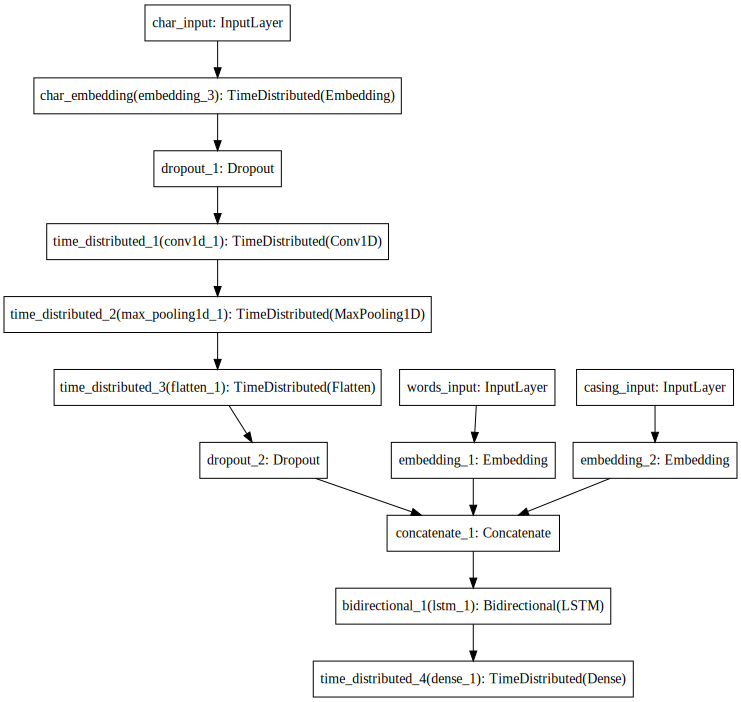

In [98]:
words_input = Input(shape=(None,),dtype='int32',name='words_input')
words = Embedding(input_dim=wordEmbeddings.shape[0], output_dim=wordEmbeddings.shape[1],  weights=[wordEmbeddings], trainable=False)(words_input)
casing_input = Input(shape=(None,), dtype='int32', name='casing_input')
casing = Embedding(output_dim=caseEmbeddings.shape[1], input_dim=caseEmbeddings.shape[0], weights=[caseEmbeddings], trainable=False)(casing_input)
character_input=Input(shape=(None,52,),name='char_input')
embed_char_out=TimeDistributed(Embedding(len(char2Idx),30,embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(character_input)
dropout= Dropout(0.5)(embed_char_out)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(52))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)
output = concatenate([words, casing,char])
output = Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25))(output)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)
model = Model(inputs=[words_input, casing_input,character_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam')
model.summary()
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [120]:
for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
    labels, tokens, casing,char = batch
    break

For a single sample

In [121]:
labels.shape

(179, 1, 1)

In [122]:
tokens.shape

(179, 1)

In [123]:
casing.shape

(179, 1)

In [124]:
char.shape

(179, 1, 52)

In [136]:
labels[:5]

array([[[6]],

       [[8]],

       [[0]],

       [[8]],

       [[8]]])

In [132]:
tokens[:5]

array([[    4],
       [15954],
       [  231],
       [    1],
       [    1]])

In [133]:
casing[:5]

array([[4],
       [2],
       [2],
       [2],
       [2]])

In [134]:
char[:5]

array([[[65,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]],

       [[58, 46, 39, 61, 56, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]],

       [[47, 56, 39, 55,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]],

       [[39, 52, 67, 52, 39, 46, 39, 56,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0]],

       [[39,

In [139]:
epochs=50
for epoch in range(epochs):    
    print("Epoch %d/%d"%(epoch,epochs))
    a = Progbar(len(train_batch_len))
    for i,batch in enumerate(iterate_minibatches(train_batch,train_batch_len)):
        labels, tokens, casing,char = batch       
        model.train_on_batch([tokens, casing,char], labels)
        a.update(i)
    print(' ')

Epoch 0/50
63/64 [============================>.] - ETA: 0s 
Epoch 1/50
63/64 [============================>.] - ETA: 0s 
Epoch 2/50
63/64 [============================>.] - ETA: 0s 
Epoch 3/50
63/64 [============================>.] - ETA: 0s 
Epoch 4/50
63/64 [============================>.] - ETA: 0s 
Epoch 5/50
63/64 [============================>.] - ETA: 0s 
Epoch 6/50
63/64 [============================>.] - ETA: 0s 
Epoch 7/50
63/64 [============================>.] - ETA: 0s 
Epoch 8/50
63/64 [============================>.] - ETA: 0s 
Epoch 9/50
63/64 [============================>.] - ETA: 0s 
Epoch 10/50
63/64 [============================>.] - ETA: 0s 
Epoch 11/50
63/64 [============================>.] - ETA: 0s 
Epoch 12/50
63/64 [============================>.] - ETA: 0s 
Epoch 13/50
63/64 [============================>.] - ETA: 0s 
Epoch 14/50
63/64 [============================>.] - ETA: 0s 
Epoch 15/50
63/64 [============================>.] - ETA: 0s 
Epoch 16/50
63/64 

In [142]:
def tag_dataset(dataset):
    correctLabels = []
    predLabels = []
    b = Progbar(len(dataset))
    for i,data in enumerate(dataset):    
        tokens, casing,char, labels = data
        tokens = np.asarray([tokens])     
        casing = np.asarray([casing])
        char = np.asarray([char])
        pred = model.predict([tokens, casing,char], verbose=False)[0]   
        pred = pred.argmax(axis=-1) #Predict the classes            
        correctLabels.append(labels)
        predLabels.append(pred)
        b.update(i)
    return predLabels, correctLabels

In [143]:
#   Performance on dev dataset        
predLabels, correctLabels = tag_dataset(dev_batch)        
pre_dev, rec_dev, f1_dev = compute_f1(predLabels, correctLabels, idx2Label)
print("Dev-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (pre_dev, rec_dev, f1_dev))
    
#   Performance on test dataset       
predLabels, correctLabels = tag_dataset(test_batch)        
pre_test, rec_test, f1_test= compute_f1(predLabels, correctLabels, idx2Label)
print("Test-Data: Prec: %.3f, Rec: %.3f, F1: %.3f" % (pre_test, rec_test, f1_test))

3450/3453 [============================>.] - ETA: 0sTest-Data: Prec: 0.883, Rec: 0.899, F1: 0.891
